# Homework 2: Implement, Tune and Evaluate your Policy Gradient and Actor-Critic Algorithms

This assignment provides a hands-on introduction to the core components of Policy Gradient (PG) and Actor-Critic (AC) methods.

For more details please checkout [HW2.md](../HW2.md)

## Setup

You will need to make a copy of this notebook in your Google Drive before you can edit the homework files. You can do so with **File &rarr; Save a copy in Drive**.

In [ ]:
#@title Mount Your Google Drive
#@markdown Your work will be stored in a folder called `cs285_f2022` by default to prevent Colab instance timeouts from deleting your edits.

import os
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
#@title Setup Mount Symlink

DRIVE_PATH = '/content/gdrive/My\ Drive/rl_class'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
  %mkdir $DRIVE_PATH

## the space in `My Drive` causes some issues,
## make a symlink to avoid this
SYM_PATH = '/content/rl_class'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

In [ ]:
#@title Apt Install Requirements

#@markdown Run each section with Shift+Enter

#@markdown Double-click on section headers to show code.

!apt update
!apt install -y --no-install-recommends \
        build-essential \
        curl \
        git \
        gnupg2 \
        make \
        cmake \
        ffmpeg \
        swig \
        libz-dev \
        unzip \
        zlib1g-dev \
        libglfw3 \
        libglfw3-dev \
        libxrandr2 \
        libxinerama-dev \
        libxi6 \
        libxcursor-dev \
        libgl1-mesa-dev \
        libgl1-mesa-glx \
        libglew-dev \
        libosmesa6-dev \
        lsb-release \
        ack-grep \
        patchelf \
        wget \
        xpra \
        xserver-xorg-dev \
        xvfb


In [ ]:
#@title Clone Homework Repo

%cd $SYM_PATH
!git clone https://<TOKEN>@<Your Personalized Github Classroom Assignement link>
# Use GitHub Personal Access Token as a password. Be careful not to expose your token; it's equivalent to a password!!! Don't commit your token!
%cd <Your Personalized Github Classroom Assignement repo>
%pip install swig
%pip install -e .
%pip install -r requirements_colab.txt


In [ ]:
# # In case we need to install the dependencies manually
# !pip install  tensorboard  torch swig gymnasium[box2d] ray[rllib] scikit-image pygame numba PyYAML GitPython tensorflow_probability

## Editing Code

To edit code, click the folder icon on the left menu. Navigate to the corresponding file (`multigrid/...`). Double click a file to open an editor. There is a timeout of about ~12 hours with Colab while it is active (and less if you close your browser window). We sync your edits to Google Drive so that you won't lose your work in the event of an instance timeout, but you will need to re-mount your Google Drive and re-install packages with every new instance.

In [1]:
#@title Imports
from __future__ import annotations

import json
import pathlib
from pathlib import Path
import os
import subprocess
import numpy as np
from dataclasses import dataclass, asdict, field
from types import SimpleNamespace
import git
from IPython.display import Image

import ray
from multigrid.envs import *
from multigrid.utils.training_utilis import algorithm_config, get_checkpoint_dir
from multigrid.scripts.train import configure_algorithm, train
from multigrid.scripts.visualize import main_evaluation


/Users/zla0368/opt/miniconda3/envs/rl_class_env_test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/zla0368/opt/miniconda3/envs/rl_class_env_test/lib/python3.10/site-packages/ray/tune/logger/tensorboardx.py:41: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  VALID_NP_HPARAMS = (np.bool8, np.float32, np.float64, np.int32, np.int64)


In [2]:
#@title Fix Variables

# Set the working diretory to the repo root
REPO_ROOT = subprocess.check_output(['git', 'rev-parse', '--show-toplevel']).strip().decode('utf-8')
os.chdir(REPO_ROOT)

SUBMISSION_CONFIG_FILE = sorted(
    Path("submission").expanduser().glob("**/submission_config.json"), key=os.path.getmtime
)[-1]

with open(SUBMISSION_CONFIG_FILE, "r") as file:
    submission_config_data = file.read()

submission_config = json.loads(submission_config_data)

SUBMITTER_NAME = submission_config["name"]

CURRENT_DIR = os.getcwd()
GIT_COMMIT_HASH =  git.Repo(REPO_ROOT).head.commit
TAGS = {"user_name": SUBMITTER_NAME, "git_commit_hash": GIT_COMMIT_HASH}

ALGORITHM_CONFIG_FILE = sorted(
    Path("submission").expanduser().glob("**/configs/algorithm_training_config.json"), key=os.path.getmtime
)[-1]

with open(ALGORITHM_CONFIG_FILE, "r") as file:
   algorithm_training_config_data = file.read()

algorithm_training_config = json.loads(algorithm_training_config_data)


## Task 1 - Familiarize Yourself with the ClearnRL PPO Implementation and Training Parameters for Deep RL Learning Loop
First, check out the CleanRL PPO implementation and its configuration in [`multigrid/scripts/train_ppo_cleanrl.py`](multigrid/scripts/train_ppo_cleanrl.py). You can do this by running the following command with the `--debug-mode True` flag.

Executing this command will display the default values of the training configuration and export a video showcasing the training scenario using random actions.

In [ ]:
! python multigrid/scripts/train_ppo_cleanrl.py --debug-mode True 

### Task 1 Questions
After running the above command, observe the outputs in the command line. This will provide essential information required to train your RL agent.


#### Questions for General Deep RL Training Parameters Understanding
**Q.1** From the command line outputs, can you report the values for the following parameters from the command line outputs? Additionally, please describe the role of each parameter in the training loop and explain how these values influence training in a sentence or two. This exercise can help you grasp the fundamentals of `Sample Efficiency` and understand the tradeoffs when scaling your training process in a parallel fashion.  

- **num_envs**: 
- **batch_size**: 
- **num_minibatches**: 
- **minibatch_size**: 
- **total_timesteps**: 
- **num_updates**: 
- **num_steps**: 
- **update_epochs**: 

> **Note**: From Week 1, recall that `Sample Efficiency` refers to the ability of an algorithm to converge to an optimal solution with minimal sampling of experience data (trajectory from steps) from the environment.

#### Tips:
- Refer to [Part 1 of 3 — Proximal Policy Optimization Implementation: 11 Core Implementation Details](https://www.youtube.com/watch?v=MEt6rrxH8W4) from Week 2's Curriculum.
- Extensive comments and docstrings have been added atop the original [CleanRL ppo.py](https://github.com/vwxyzjn/cleanrl/blob/master/cleanrl/ppo.py) for your reference.
- Explore different configurations for the V2 environment in `CONFIGURATIONS` within [envs/__init__.py].
- Feel free to experiment with various arguments in [`multigrid/scripts/train_ppo_cleanrl.py`](multigrid/scripts/train_ppo_cleanrl.py) to familiarize yourself with this training script, its parameters, and the significance of the command line outputs.

#### Notes:
1. We only utilize the CleanRL PPO implementation in the first three main tasks of HW2. However, it offers a clean and straightforward way to grasp the ins and outs of the algorithm.
2. It's beneficial to explore other PPO implementations in CleanRL's official repository. For example:
    - [ppo_atari.py](https://github.com/vwxyzjn/cleanrl/blob/master/cleanrl/ppo_atari.py)
    - [ppo_atari_lstm.py](https://github.com/vwxyzjn/cleanrl/blob/master/cleanrl/ppo_atari_lstm.py)
    - [ppo_continuous_action.py](https://github.com/vwxyzjn/cleanrl/blob/master/cleanrl/ppo_continuous_action.py)


---
## Task 2 - Understand the Deep RL Training Loop Dataflow & Implement Techniques to Minimize Learning Variance

In this task, you will delve into the specifics of the vectorized training architecture, which consists of two pivotal phases: the `Rollout Phase` and the `Learning Phase`. This is the parallelized training architecture that many Deep RL algorithms, including PPO used. You will also explore the techniques employed by PPO to reduce variance in learning, particularly focusing on the Generalized Advantage Estimation (GAE). You will enhance your understanding by identifying these phases in the code and implementing GAE to reduce variance of the training data before the `Learning Phase` when using the diversed data collected from the `Rollout Phase`.

### Questions to Enhance Understanding of the Deep RL Training Loop
***Q.1*** As mentioned in [The 37 Implementation Details of Proximal Policy Optimization](https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details/), PPO employs a streamlined paradigm known as the vectorized architecture. This architecture encompasses two phases within the training loop:

- **Rollout Phase**: During this phase, the agent samples actions for 'N' environments and continues to process them for a designated 'M' number of steps.

- **Learning Phase**: In this phase, fundamentally, the agent learns from the data collected during the rollout phase. This data, with a length of NM, includes 'next_obs' and 'done'.

Utilizing your baseline codebase tagged `v2.1`, please pinpoint the `Rollout Phase` and the `Learning Phase` within the codebase, indicating specific line numbers. 

* For instance, the lines [189-211 in CleanRL ppo.py](https://github.com/vwxyzjn/cleanrl/blob/master/cleanrl/ppo.py#L189-L211) represent the Rollout Phase in their PPO implementation.  

**Q.2 How does PPO Reduce Variance? By Utilizing Generalized Advantage Estimation (GAE)? What is that?**

> **Note**: 
  PPO employs the Generalized Advantage Estimation (GAE) method for advantage calculation, merging multiple n-step estimators into a singular estimate, thereby mitigating variance and fostering more stable and efficient training.

  GAE amalgamates multiple n-step advantage estimators into a singular weighted estimator represented as:
  
      A_t^GAE(γ,λ) = Σ(γλ)^i δ_(t+i)

  
  where:
  
      δ_t - The temporal difference error formally defined as δ_t = r_t + γV(s_(t+1)) - V(s_t)
      γ - Discount factor which determines the weight of future rewards
      λ - A hyperparameter in [0,1] balancing bias and variance in the advantage estimation

  **References**:
  "High-Dimensional Continuous Control Using Generalized Advantage Estimation" by John Schulman et al.


If you run the following training command to train an agent, you are expected to see ValueErrors from blanks that needed to be filled to implement and enable Generalized Advantage Estimation (GAE). Please make use of the comments in the code to help you to implement GAE. 




Command for Task 2:


In [ ]:
! python multigrid/scripts/train_ppo_cleanrl.py --env-id MultiGrid-CompetativeRedBlueDoor-v2-DTDE-Red-Single --num-envs 8 --num-steps 128 --learning-rate 3e-4 --total-timesteps 10000000 --exp-name baseline

#### Tips:
- Useful comments has been added to the code for your guidance.
- For further insight, you might refer to the ["Generalized Advantage Estimation" section in "The 37 Implementation Details of Proximal Policy Optimization"](https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details/).


 ---
 ## Initialize and Show Tensorboard Before Training

 Filter tags for key performance metrics:


In [5]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [6]:
# Start TensorBoard and Map the `logdir`` to `save_dir` i.e. `/content/gdrive/MyDrive/rl_class/week-1-intro-to-deep-rl-and-agent-training-environment/submission/cleanRL/runs`
%tensorboard --logdir submission/cleanRL/runs --port 6007

Reusing TensorBoard on port 6007 (pid 28488), started 17:27:12 ago. (Use '!kill 28488' to kill it.)

---

## Task 3 - Tuning the 🎲 **Exploration & Exploitation Strategies** using Algorithm-Specific Hyperparameters

Having implemented GAE in Task 2, re-run the training command provided below to start agent training. You're encouraged to adjust or introduce additional parameters as required.

In [ ]:
! python ../multigrid/scripts/train_ppo_cleanrl.py --env-id MultiGrid-CompetativeRedBlueDoor-v2-DTDE-Red-Single-with-Obstacle --num-envs 8 --num-steps 128 --learning-rate 3e-4 --total-timesteps 10000000 --exp-name baseline


### Deepening Your Understanding to Interpret Your Results
***Q.1*** Train a baseline agent using default or adjusted parameter values. Capture and present Tensorboard screenshots to report the following training metrics. Indicate the `Sample Effiicency`, the number of training timesteps and policy updates, required to achieve the Training Baseline Thresholds:

- **episodic_length**
- **episodic_return**
- **policy_updates**
- **entropy**
- **explained_variance**
- **value_loss**
- **policy_loss**
- **approx_kl**

**CleanRL Agent Training Baseline Thresholds for Your Reference**:
- `episodic_length` should converge to a solution within 40 time steps and maintain for at least 100k time steps at the end of training.
- `episodic_return` should converge to consistently achieve 2.0+ returns, enduring for a minimum of the last 100k time steps.
- `explained_variance` should stabilize at a level above 0.6 for at least the last 100k time steps.
- `entropy` should settle at values below 0.3 for a minimum of 100k final training steps.


### Hands-on Experiences on PPO-Specific Hyperparameters
***Q.2*** If your baseline agent struggles to achieve the Training Baseline Thresholds, or if there's potential for enhancment, now you are getting the chance to fine-tuning the following PPO-specific parameters discussed in class to improve the performance of your agent. You may want to run multiple versions of experinements, so remember to modify `--exp-name` to differentiate between agent configurations. For final submissions, pick the top 3 performing or representable results and present the training metrics via screenshots and specify the number of timesteps and policy updates needed to fulfill or surpass the Training Baseline Thresholds. (Including links to their videos will be ideal)

- **gamma**
- **gae-lambda**
- **clip-coef**
- **clip-vloss**
- **ent-coef**
- **vf-coef**
- **target-kl**

Additionally, consider tweaking the following generic Deep RL hyperparameters:

- **num_envs**
- **batch_size**
- **num_minibatches**
- **minibatch_size**
- **total_timesteps**
- **num_updates**
- **num_steps**
- **update_epochs**

**Tips:**
- Monitor and track your runs using Tensorboard with the following command:
  ```shell
  tensorboard --logdir submission/cleanRL/runs
  ```
- Please refer Week2 lecture slide for the definition of the PPO-specific parameters
- As mentioned in [The 37 Implementation Details of Proximal Policy Optimization](https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details/): 
  - The significance of Value Function Loss Clipping is debatable. Engstrom, Ilyas, et al., (2020) didn't find evidence supporting its performance boost. In contrast, Andrychowicz, et al. (2021) inferred it might even hurt overall performance.
  - For Early Stopping, consider setting the target kl to `0.01`, as demonstrated in [OpenAI's PPO PyTorch Implementation](https://spinningup.openai.com/en/latest/algorithms/ppo.html#documentation-pytorch-version). 
  - `CompetativeRedBlueDoorEnvV2` is redundent on purpose so that you can modify it with the Deep RL knowledge you have learned so far to solve the `MultiGrid-CompetativeRedBlueDoor-v2-DTDE-Red-Single-with-Obstacle` scenario. 


---
## Extra Challenge #1: Mastering a Scenario with Sparse Learning Signals and Lower Complexity

Are you interested in challenging yourself further? Try to solve the scenario `MultiGrid-CompetitiveRedBlueDoor-v2-DTDE-Red-Single`. Intriguingly, the default agent configuration can solve the scenario with obstacle easily, but falters when there are none. 


See if you can solve the `MultiGrid-CompetativeRedBlueDoor-v2-DTDE-Red-Single`. Supprisingly, the default agent config can solve the scenario with obsticles, but not the scenario without. One possible explanation could be the close proximity of the obstacle to the door. Coupled with the annealing `ball_pickup_dense_reward`, these additional observations might act as additional learning signal, helping the agent overcome partial observability challenges and identify the sparse goal: opening the door using the key. But is this theory grounded in reality?

We invite you to investigate this by addressing the same questions outlined in Task 3. Share your findings and discoveries from this challenge in your `HW2_Answer.md` file.

**Tips**:
- Be on the lookout for potential bugs lurking within the training code or the environment. Andy Jones' insightful piece, [Debugging RL, Without the Agonizing Pain](https://andyljones.com/posts/rl-debugging.html), can be a valuable resource in debugging the environment.
- The `CompetitiveRedBlueDoorEnvV2` has been intentionally designed to be modifiable, and is not monitored by the CI/CD pipeline, providing you with the freedom to apply the deep RL concepts, you've learned so far to successfully navigate the `MultiGrid-CompetitiveRedBlueDoor-v2-DTDE-Red-Single` scenario.
- Similarly, the `CompetitiveRedBlueDoorWrapperV2` was created to allow for customization, enabling you to alter the raw observations received from the unwrapped upstream environment. This grants you the flexibility to define your very own observation and action spaces.

---

## Task 4: Bring the Lessons Learned from CleanRL to RLlib to solve a 1v1, 🤖 🆚 🤖 Scenario 

As you get familiar with PPO by working through the CleanRL implementation, let's pivot back to RLlib. We'll harness our understanding of hyperparameter tuning to address a 1v1 competition with a pre-trained opponent.


## For Agent Training


Once you are familiar with the new scenario `MultiGrid-CompetativeRedBlueDoor-v3-DTDE-1v1`, you can set up your Training Arguments below


In [7]:
#@title Training Arguments
@dataclass
class Args:

    #@markdown agent config
    num_agents: int = 1 #@param {type: "integer"}
    algo: str = "PPO"  #@param {type: "string"}
    framework: str = "torch" #@param ['torch', 'tf2']
    lstm: bool = False #@param {type:"boolean"}
    training_scheme: str = "DTDE"  #@param ['CTCE', 'DTDE', 'CTDE']
    policies_to_train_raw: str = "red_0" #@param {type: "raw"}
    policies_to_load_raw: str = "blue_0" #@param {type: "raw"}

    #@markdown environemnt config
    env: str = "MultiGrid-CompetativeRedBlueDoor-v3-DTDE-1v1"  #@param {type: "string"}

    #@markdown training config
    num_workers: int = 10  #@param {type: "integer"}
    num_gpus: int = 0 #@param {type: "integer"}
    lr: float = 0.001  #@param {type: "float"}
    # NOTE Please only keep the checkpoints that you want to submit
    save_dir: str = "submission/ray_results/" #@param {type: "string"}
    load_dir: str = "submission/pretrained_checkpoints/PPO_MultiGrid-CompetativeRedBlueDoor-v3-DTDE-1v1_154ab_00000_0_2023-09-12_16-08-06/checkpoint_000250" #@param {type:"string"}
    user_name: str = "HengLee" #@param {type: "string"}
    experiment_name: str = "1v1_Testing" #@param {type: "string"}
    mlflow_tracking_uri: str = "submission/mlflow/", #@param {type: "string"}
    checkpoint_freq: int = 20 #@param {type: "integer"}
    num_timesteps: float = 1e6 #@param {type: "string"}
    checkpoint_freq: int = 20 #@param {type: "integer"}
    seed: int = 1 #@param {type: "integer"}
    local_mode: bool = False  #@param {type:"boolean"}

    #@markdown Algorithm Specific Configs (Please enter valid JSON)
    algorithm_training_config_str: str = '''{
        "algorithm_training_config": {
            "PG_params": {
                "gamma": 0.99
            },
            "PPO_params": {
                "lambda_": 0.99,
                "kl_coeff": 0.2,
                "kl_target": 0.01,
                "clip_param": 0.3,
                "grad_clip": null,
                "vf_clip_param": 10.0,
                "vf_loss_coeff": 0.5,
                "entropy_coeff": 0.001,
                "sgd_minibatch_size": 128,
                "num_sgd_iter": 30
            }
        }
    }''' #@param {type:"raw"}

    algorithm_training_config: dict = field(default_factory=dict)

    def to_namespace(self):
        # Convert the JSON string to dictionary
        parsed_algo_config = json.loads(self.algorithm_training_config_str)
        self.algorithm_training_config = parsed_algo_config['algorithm_training_config']
        return SimpleNamespace(**asdict(self))






In [8]:
#@title Set up Training Arguments
args = Args().to_namespace()
args.multiagent = {}
args.multiagent["policies_to_train"] = args.policies_to_train_raw.split(",")

print(args) # Prints the values of all attributes

config = configure_algorithm(args)
stop_conditions = {"timesteps_total": args.num_timesteps}


2023-09-16 15:58:32,319	WARNING deprecation.py:50 -- DeprecationWarning: `rllib/algorithms/a3c/a3c.py` has been deprecated. Use `rllib_contrib/a3c/` instead. This will raise an error in the future!
2023-09-16 15:58:32,320	WARNING deprecation.py:50 -- DeprecationWarning: `rllib/algorithms/a3c/a3c.py` has been deprecated. Use `rllib_contrib/a3c/` instead. This will raise an error in the future!


namespace(num_agents=1, algo='PPO', framework='torch', lstm=False, training_scheme='DTDE', policies_to_train_raw='red_0', policies_to_load_raw='blue_0', env='MultiGrid-CompetativeRedBlueDoor-v3-DTDE-1v1', num_workers=10, num_gpus=0, lr=0.001, save_dir='submission/ray_results/', load_dir='submission/pretrained_checkpoints/PPO_MultiGrid-CompetativeRedBlueDoor-v3-DTDE-1v1_154ab_00000_0_2023-09-12_16-08-06/checkpoint_000250', user_name='HengLee', experiment_name='1v1_Testing', mlflow_tracking_uri=('submission/mlflow/',), checkpoint_freq=20, num_timesteps=1000000.0, seed=1, local_mode=False, algorithm_training_config_str='{\n        "algorithm_training_config": {\n            "PG_params": {\n                "gamma": 0.99\n            },\n            "PPO_params": {\n                "lambda_": 0.99,\n                "kl_coeff": 0.2,\n                "kl_target": 0.01,\n                "clip_param": 0.3,\n                "grad_clip": null,\n                "vf_clip_param": 10.0,\n            

2023-09-16 15:58:32,517	WARNING deprecation.py:50 -- DeprecationWarning: `rllib/algorithms/maml/maml.py` has been deprecated. Use `rllib_contrib/maml/` instead. This will raise an error in the future!


## Execute training

In [12]:
#@title Execute Training
train(
    algo=args.algo,
    config=config,
    stop_conditions=stop_conditions,
    save_dir=args.save_dir,
    load_dir=args.load_dir,
    local_mode=args.local_mode,
    experiment_name=args.experiment_name,
    training_scheme=args.training_scheme,
    policies_to_load=args.policies_to_load_raw.split(","),  
)

# NOTE - Please remember to clear your training outputs before you submit your notebook to reduce file size and increase readability

2023-09-16 15:18:29,751	INFO tune.py:1111 -- Total run time: 134.28 seconds (123.96 seconds for the tuning loop).
2023-09-16 15:18:29,753	WARNING tune.py:1126 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: tune.run(..., resume=True)


In [ ]:
# NOTE-  Manually shutdown Ray if needed
ray.shutdown()

### Q.1 Metrics to Report:

As the same as Task 2&3, document the following training metrics, showcasing them with screenshots. Also, detail the number of timesteps and policy updates that meet or exceed the Training Baseline Thresholds.

Here are the RLLib and Scenario specific metrics:

- **episode_len_mean**
- **ray/tune/policy_reward_mean/red_0**
- **ray/tune/policy_reward_mean/blue_0**
- **ray/tune/sampler_results/custom_metrics/red_0/door_open_done_mean**
- **ray/tune/sampler_results/custom_metrics/blue_0/door_open_done_mean**
- **ray/tune/sampler_results/custom_metrics/red_0/eliminated_opponents_done_mean**
- **ray/tune/sampler_results/custom_metrics/blue_0/eliminated_opponents_done_mean**
- **ray/tune/counters/num_agent_steps_trained**
- **ray/tune/counters/num_agent_steps_sampled**
- **ray/tune/counters/num_env_steps_sampled**
- **ray/tune/counters/num_env_steps_trained**
- **episodes_total**
- **episodes_this_iter**
- **red_0/learner_stats/cur_kl_coeff**
- **red_0/learner_stats/entropy**
- **red_0/learner_stats/grad_gnorm**
- **red_0/learner_stats/kl**
- **red_0/learner_stats/policy_loss**
- **red_0/learner_stats/total_loss**
- **red_0/learner_stats/vf_explained_var**
- **red_0/learner_stats/vf_loss**
- **red_0/num_grad_updates_lifetime**



Here are the PPO-specific parameters in RLLib:
- **gamma**
- **lambda_**
- **kl_coeff**
- **kl_target**
- **clip_param**
- **grad_clip**
- **vf_clip_param**
- **vf_loss_coeff**
- **entropy_coeff**

**RLlib Agent Training Baseline Thresholds for Your Reference**:
- `episode_len_mean` should converge to a solution within 20 time steps and maintain for at least 100k time steps at the end of training.
- `ray/tune/policy_reward_mean/red_0` should converge to consistently achieve 1.3+ returns, enduring for a minimum of the last 100k time steps.
- `explained_variance` should stabilize at a level above 0.4 for at least the last 100k time steps.
- `red_0/learner_stats/entropy` should settle at values below 0.3 for a minimum of 100k final training steps.

**RLlib Agent Behavior Analysis Thresholds**
The following Metrics are Behavior-specific metrics. It depends on how your agent emerges into certain specific behaviors to achieve the RL objective to maximize the discounted sum of rewards from time step t to the end of the game. So, how to achieve the maximum return depends on the training environment's world dynamic and the agent's reward structures. So, the "Player Archetypes" of your agent can be varied. 

Our training scenario can be interpreted as a Zero-Sum game. Therefore, if your agent learned to solve a particular scenario by unlocking the door first, your Red agent should dominate this metric. Vice Versa.
- **ray/tune/sampler_results/custom_metrics/red_0/door_open_done_mean**
- **ray/tune/sampler_results/custom_metrics/blue_0/door_open_done_mean**

As mentioned above, if your agent learned to solve a particular scenario by eliminating the opponent first, your Red agent should dominate this metric. Vice Versa.
- **ray/tune/sampler_results/custom_metrics/red_0/eliminated_opponents_done_mean**
- **ray/tune/sampler_results/custom_metrics/blue_0/eliminated_opponents_done_mean**


For final submitions, pick the top 3 performing or representable results and present the training metrics via screenshots and specify the number of timesteps and policy updates needed to fulfill or surpass the Training Baseline Thresholds



**Tips:**
- Take a look at the configuration of `MultiGrid-CompetativeRedBlueDoor-v3-DTDE-1v1` in  [envs/__init__.py](multigrid/envs/__init__.py)
- You can filter the plots using the following filters:

```
eliminated_opponents_done_mean|episode_len_mean|num_agent_steps_trained|num_agent_steps_sampled|num_env_steps_sampled|num_env_steps_trained|episodes_total|red_0/learner_stats/cur_kl_coeff|red_0/learner_stats/entropy|red_0/learner_stats/grad_gnorm|red_0/learner_stats/kl|red_0/learner_stats/policy_loss|red_0/learner_stats/total_loss|red_0/learner_stats/vf_explained_var|red_0/learner_stats/vf_loss|red_0/num_grad_updates_lifetime|ray/tune/policy_reward_mean/red_0|ray/tune/policy_reward_mean/blue_0
```
- RLlib Tune may report metrics with different names but pointing to the same metric. For example, `ray/tune/sampler_results/custom_metrics/blue_0/door_open_done_mean` is the same as `ray/tune/custom_metrics/blue_0/door_open_done_mean` so just report one is fine.



## Submission for Task 4 - Monitor and Track Agent Training with Tensorboard and Save Out Visualization from Evaluation

1. Please take screenshots of your Tensorboard plots that highlight your performance metrics
2. Embedd your images here in CoLab
3. Only save the best checkpoint and video in the /submission folder and push to your repo


In [ ]:
from google.colab import files
from IPython.display import Image

uploaded = files.upload()

# Assuming a single image file is uploaded
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
  display(Image(fn))

In [ ]:
#@title Your Tensorboard Screenshots Go Here
...

---
## Extra Challenge #2: Exploring Different RLLib Algorithms
Are you interested in challenging yourself further? See if you can solve the same scenario using alternative [Deep RL Algorithms](https://docs.ray.io/en/latest/rllib/rllib-algorithms.html#available-algorithms-overview) provided by RLLib.

To experiment with different algorithms, adjust the `--algo` flag to specify an alternate RLlib-registered algorithm.

**Tips**:
- Review the supported conditions for each algorithm. Look for specific requirements or features like `Discrete Actions`, `Continuous Actions`, `Multi-Agent`, and `Model Support`.
- Be aware: this RL class codebase is tested for PPO. Switching directly to other algorithms may introduce unexpected issues. The most straightforward adjustments might involve changing algorithm-specific parameters. More complex modifications could entail code changes to accommodate specific observation or action spaces.



---
## Agent Evaluation

#### *For running the Evaluation, we recommend restarting the kernel first to avoid any possible environmental issues that linger from training

In [3]:

#@title Evaluation Arguments

@dataclass
class EvalArgs:

  #@markdown agent config
  algo: str = "PPO"  #@param {type: "string"}
  framework: str = "torch" #@param ['torch', 'tf2']
  lstm: bool = False #@param {type: "boolean"}

  #@markdown environemnt config
  env: str = "MultiGrid-CompetativeRedBlueDoor-v3-DTDE-1v1"  #@param {type: "string"}
  env_config: Dict = field(default_factory=dict)  # Use default_factory to create a new dict for each instance

  #@markdown Evaluation config
  num_episodes: int = 10 #@param {type: "integer"}
  load_dir: str = "submission/ray_results/1v1_Testing/PPO_MultiGrid-CompetativeRedBlueDoor-v3-DTDE-1v1_fbd9b_00000_0_2023-09-15_23-56-15/checkpoint_000140" #@param {type: "string"}
  save_dir: str = "submission/evaluation_reports/" #@param {type: "string"}
  gif: str = "DTDE-1v1-testing" #@param {type: "string"}
  render_mode: str = "human" #@param {type: "string"}
  policies_to_eval_raw: str = "red_0" #@param {type: "raw"}

  def to_namespace(self):
    return SimpleNamespace(**asdict(self))

In [6]:
#@title Set up Evaluation Arguments

eval_args = EvalArgs().to_namespace()
eval_args.policies_to_eval = eval_args.policies_to_eval_raw.split(",")
print(eval_args)  # Prints the values of all attributes

namespace(algo='PPO', framework='torch', lstm=False, env='MultiGrid-CompetativeRedBlueDoor-v3-DTDE-1v1', env_config={}, num_episodes=10, load_dir='submission/ray_results/1v1_Testing/PPO_MultiGrid-CompetativeRedBlueDoor-v3-DTDE-1v1_fbd9b_00000_0_2023-09-15_23-56-15/checkpoint_000140', save_dir='submission/evaluation_reports/', gif='DTDE-1v1-testing', render_mode='human', policies_to_eval_raw='red_0', policies_to_eval=['red_0'])


In [7]:
#@title Execute Evaluation
exported_gif_filename = main_evaluation(args=eval_args)

2023-09-16 16:07:10,676	WARNING deprecation.py:50 -- DeprecationWarning: `rllib/algorithms/a3c/a3c.py` has been deprecated. Use `rllib_contrib/a3c/` instead. This will raise an error in the future!
2023-09-16 16:07:10,677	WARNING deprecation.py:50 -- DeprecationWarning: `rllib/algorithms/a3c/a3c.py` has been deprecated. Use `rllib_contrib/a3c/` instead. This will raise an error in the future!
2023-09-16 16:07:10,840	WARNING deprecation.py:50 -- DeprecationWarning: `rllib/algorithms/maml/maml.py` has been deprecated. Use `rllib_contrib/maml/` instead. This will raise an error in the future!
/Users/zla0368/opt/miniconda3/envs/rl_class_env_test/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:20: UserWarning: WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: int64. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.
  logger.warn(
/Users/zla0368/opt/miniconda3/en

Loading checkpoint from submission/ray_results/1v1_Testing/PPO_MultiGrid-CompetativeRedBlueDoor-v3-DTDE-1v1_fbd9b_00000_0_2023-09-15_23-56-15/checkpoint_000140


2023-09-16 16:07:14,954	INFO worker.py:1636 -- Started a local Ray instance.
2023-09-16 16:07:17,385	INFO trainable.py:918 -- Restored on 127.0.0.1 from checkpoint: submission/ray_results/1v1_Testing/PPO_MultiGrid-CompetativeRedBlueDoor-v3-DTDE-1v1_fbd9b_00000_0_2023-09-15_23-56-15/checkpoint_000140
2023-09-16 16:07:17,386	INFO trainable.py:927 -- Current state after restoring: {'_iteration': 140, '_timesteps_total': None, '_time_total': 4343.256365060806, '_episodes_total': 12584}



 -------------------------------- 
 Episode 0 
 --------------------------------

 Rewards: {'red_0': -0.5, 'blue_0': 1.4689999999999999}

 Total Time Steps: 10

 Solved: True

 -------------------------------- 
 Episode 1 
 --------------------------------

 Rewards: {'red_0': 0.5, 'blue_0': 1.458}

 Total Time Steps: 14

 Solved: True

 -------------------------------- 
 Episode 2 
 --------------------------------

 Rewards: {'red_0': 1.4609999999999999, 'blue_0': 0.5}

 Total Time Steps: 13

 Solved: True

 -------------------------------- 
 Episode 3 
 --------------------------------

 Rewards: {'red_0': 1.4569999999999999, 'blue_0': -0.5}

 Total Time Steps: 14

 Solved: True

 -------------------------------- 
 Episode 4 
 --------------------------------

 Rewards: {'red_0': 1.455, 'blue_0': 0.499}

 Total Time Steps: 15

 Solved: True

 -------------------------------- 
 Episode 5 
 --------------------------------

 Rewards: {'red_0': 1.455, 'blue_0': 0.498}

 Total Time St

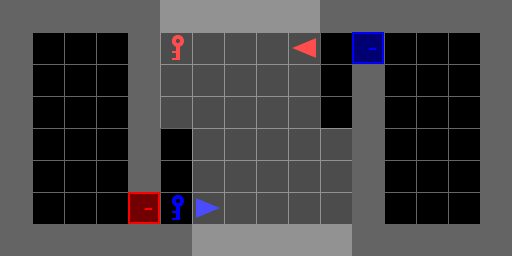

In [8]:
#@title Visualize and Display Evaluated Agent Behavniors

# Load the GIF
display(Image(filename=exported_gif_filename))

# Recommendations for Homework Submission
Backup and download your notebook first from Google CodeLab

In [ ]:
#@title Makesure you are already in YOUR_REPO_FOLDER i.e. /content/rl_class/multigrid
!pwd

In [ ]:
#@title Configure Git
!git config --global user.email "your-email@example.com"
!git config --global user.name "Your Name"


In [ ]:
#@title Move the Notebook to the Repo Folder (Optional)
!mv "your-homework1.ipynb" "/content/YOUR_REPO_FOLDER/notebooks"


In [ ]:
#@title Add, Commit and Push Changes to GitHub Classroom

!git add .
!git commit -m "Your commit message"
!git push origin main